In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['train', 'test']


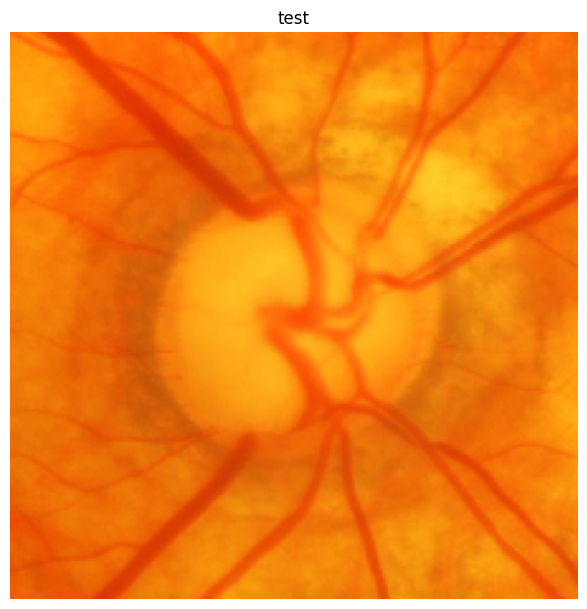

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img


base_path = "/content/drive/My Drive/acrima"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0


    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name)
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue


        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

326 Glaucoma images
239 Non Glaucoma images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "/content/drive/My Drive/acrima/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


Found 478 validated image filenames belonging to 2 classes.
📊 Nouvelle distribution des classes :
 class
Glaucoma        239
Non Glaucoma    239
Name: count, dtype: int64


<ipython-input-4-eaed69ba74d9>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


local_weights_path = "imagenet"
IMG_SHAPE = (224, 224, 3)


from tensorflow.keras.applications import VGG16


baseModel = VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=local_weights_path
)


print("Number of layers in the base model: ", len(baseModel.layers))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  19


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
def create_model():

    for layer in baseModel.layers[:17]:
        layer.trainable = False
    for layer in baseModel.layers[17:]:
        layer.trainable = True


    model = models.Sequential([
        baseModel,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
def balance_dataframe(df, label_col='class'):
    min_size = df[label_col].value_counts().min()
    balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    return balanced_df

In [ ]:
model=create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 2,392,705 (9.13 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Fold 1/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.5351 - loss: 0.7882 - val_accuracy: 0.5312 - val_loss: 0.6822
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.4992 - loss: 0.7428 - val_accuracy: 0.7500 - val_loss: 0.6553
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6073 - loss: 0.6777 - val_accuracy: 0.7917 - val_loss: 0.6314
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.6169 - loss: 0.6533 - val_accuracy: 0.8438 - val_loss: 0.6015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6140 - loss: 0.6469 - val_accuracy: 0.8646 - val_loss: 0.5794
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6636 - loss: 0.6271 - val_accuracy: 0.9271 - val_loss: 0.5530
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.7240 - loss: 0.5827 - val_accuracy: 0.8958 - val_loss: 0.5270
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.8044 - loss: 0.5492 - val_accur

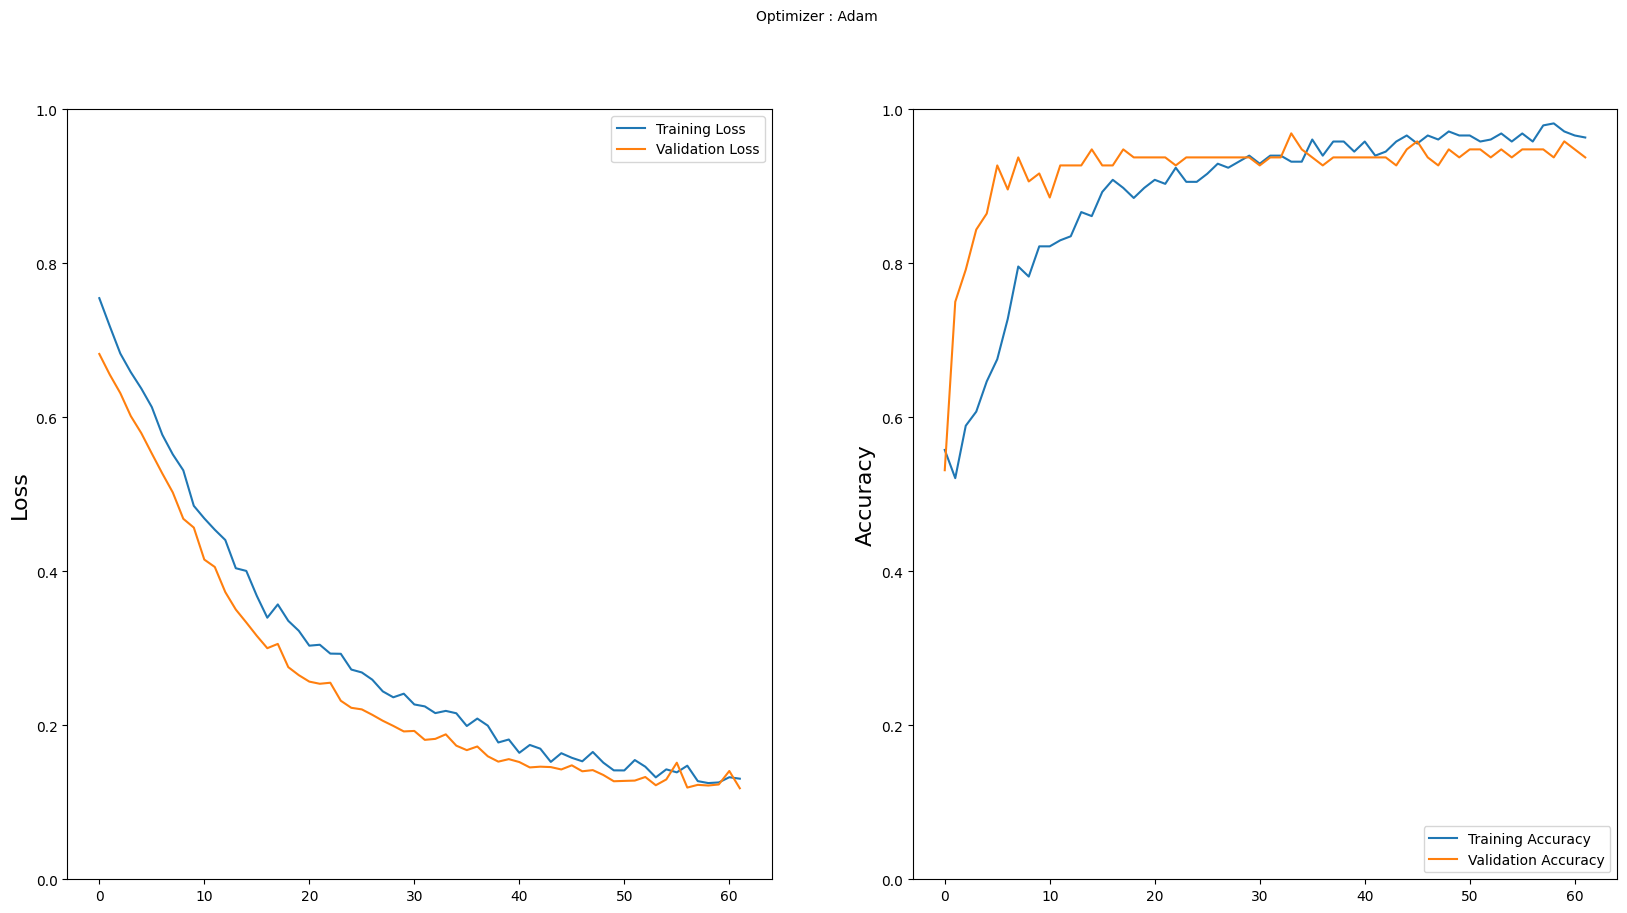

Fold 2/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.4425 - loss: 0.8560 - val_accuracy: 0.6250 - val_loss: 0.6364
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5980 - loss: 0.6700 - val_accuracy: 0.7708 - val_loss: 0.5772
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7924 - loss: 0.5560 - val_accuracy: 0.7812 - val_loss: 0.5365
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.8292 - loss: 0.5005 - val_accuracy: 0.8021 - val_loss: 0.5068
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.8094 - loss: 0.4892 - val_accuracy: 0.8333 - val_loss: 0.4848
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.8476 - loss: 0.4619 - val_accuracy: 0.8229 - val_loss: 0.4698
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.8882 - loss: 0.4259 - val_accuracy: 0.8333 - val_loss: 0.4389
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.8897 - loss: 0.4018 - val_accu

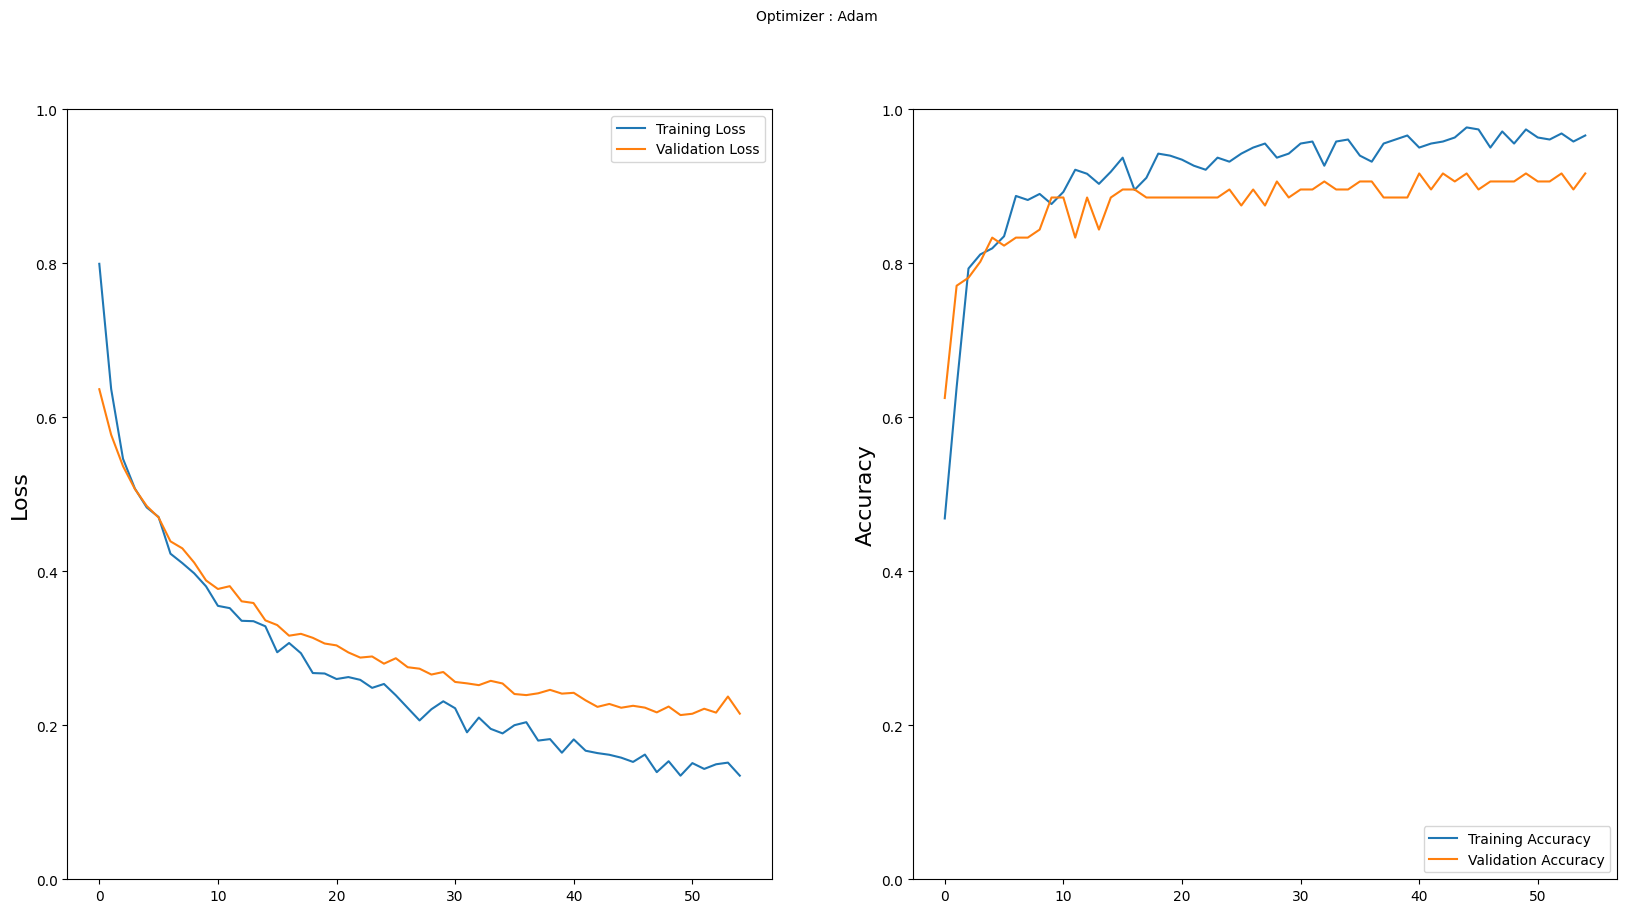

Fold 3/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 586ms/step - accuracy: 0.5612 - loss: 0.8432 - val_accuracy: 0.5521 - val_loss: 0.6404
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.5594 - loss: 0.6916 - val_accuracy: 0.8854 - val_loss: 0.5788
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7386 - loss: 0.5610 - val_accuracy: 0.8958 - val_loss: 0.5101
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.7432 - loss: 0.5533 - val_accuracy: 0.9583 - val_loss: 0.4745
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.8617 - loss: 0.4682 - val_accuracy: 0.9479 - val_loss: 0.4387
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.8948 - loss: 0.4429 - val_accuracy: 0.9583 - val_loss: 0.3984
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.8747 - loss: 0.3997 - val_accuracy: 0.9688 - val_loss: 0.3768
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.9024 - loss: 0.3674 - val_accu

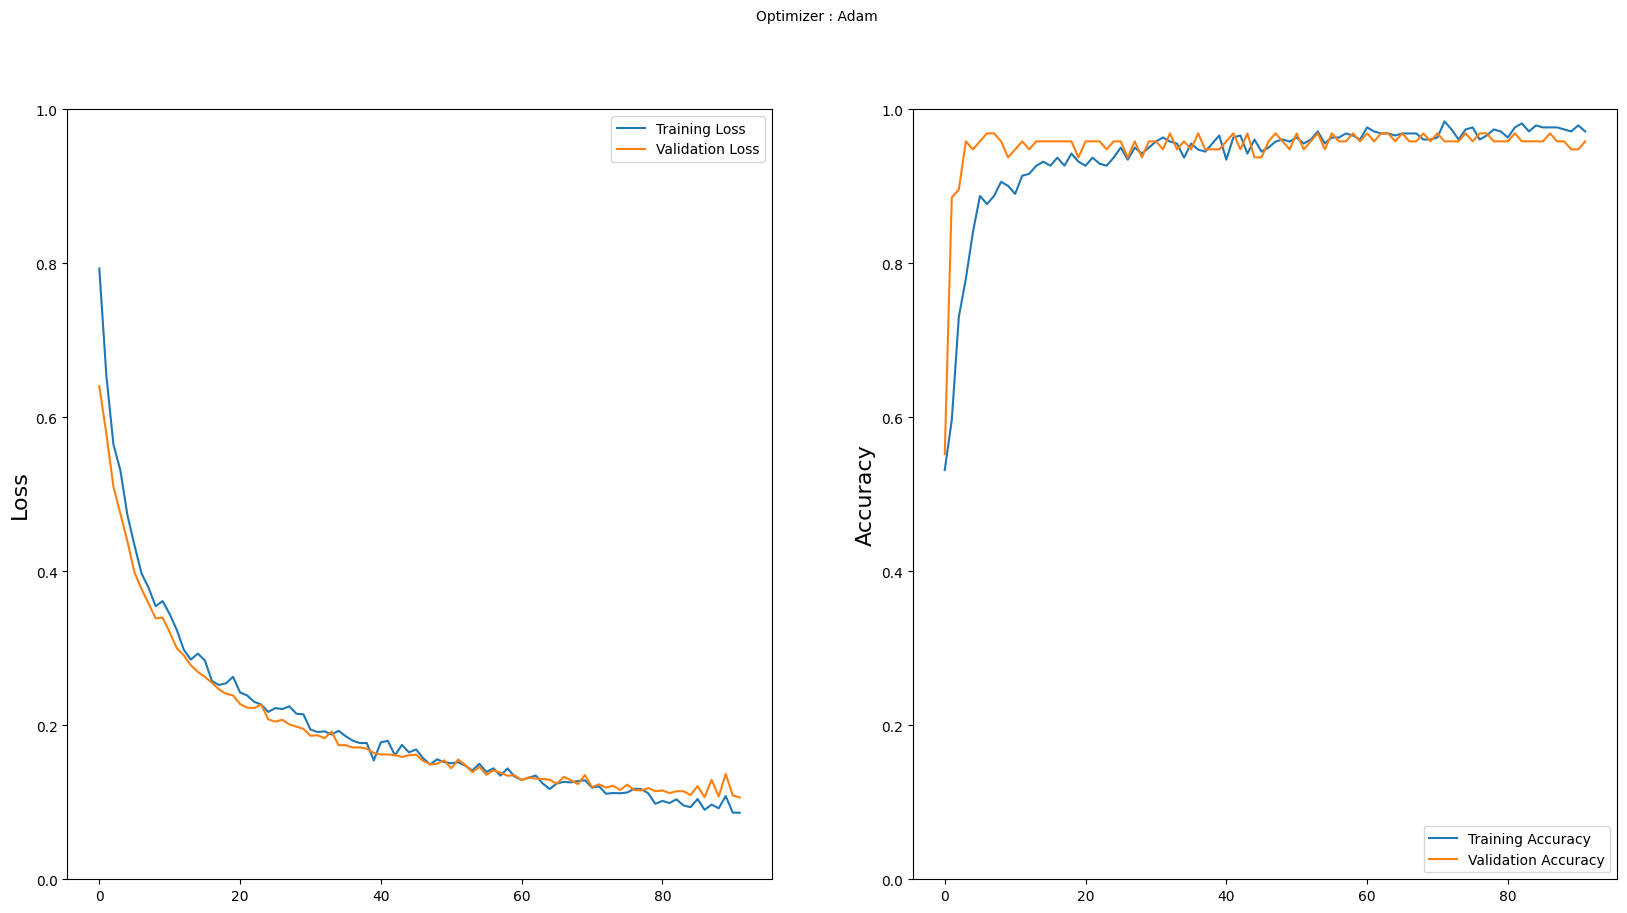

Fold 4/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4649 - loss: 1.0860 - val_accuracy: 0.8421 - val_loss: 0.5558
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.6456 - loss: 0.6169 - val_accuracy: 0.9579 - val_loss: 0.4410
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.7337 - loss: 0.5336 - val_accuracy: 0.9895 - val_loss: 0.3717
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.8334 - loss: 0.4236 - val_accuracy: 0.9895 - val_loss: 0.3345
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.8908 - loss: 0.3759 - val_accuracy: 0.9895 - val_loss: 0.2933
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.8703 - loss: 0.3645 - val_accuracy: 0.9895 - val_loss: 0.2671
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9108 - loss: 0.3142 - val_accuracy: 0.9895 - val_loss: 0.2361
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.9092 - loss: 0.3157 - val_accura

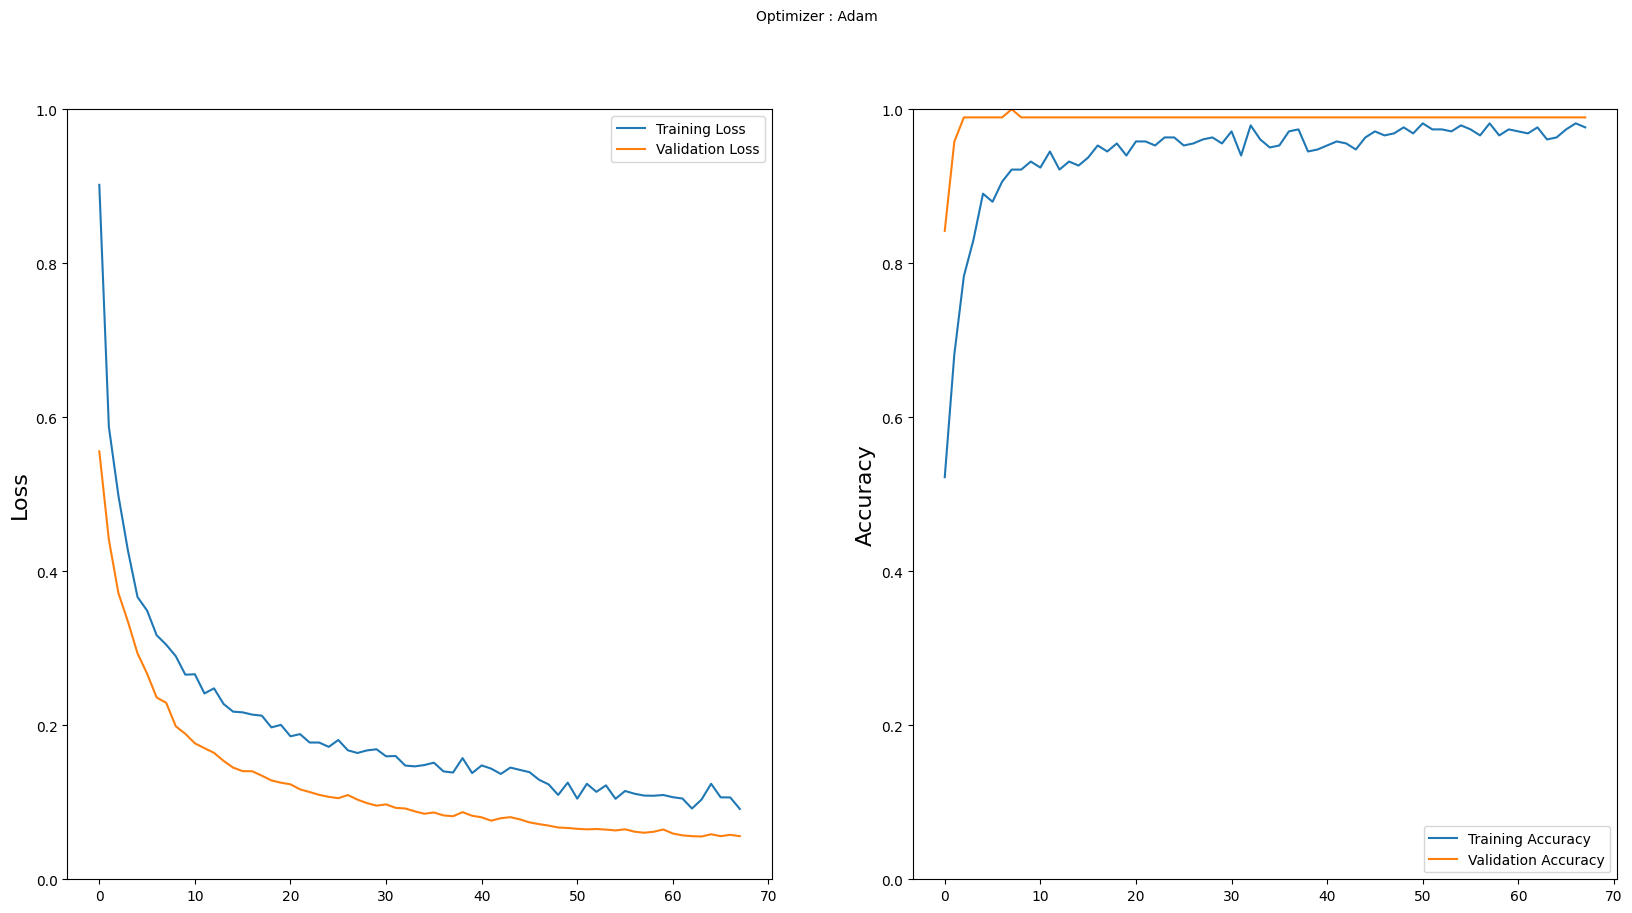

Fold 5/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - accuracy: 0.4951 - loss: 0.8167 - val_accuracy: 0.9263 - val_loss: 0.5326
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6661 - loss: 0.5981 - val_accuracy: 0.9684 - val_loss: 0.4751
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.7770 - loss: 0.5108 - val_accuracy: 0.9579 - val_loss: 0.4262
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.8751 - loss: 0.4374 - val_accuracy: 0.9684 - val_loss: 0.3720
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.8630 - loss: 0.4123 - val_accuracy: 0.9684 - val_loss: 0.3482
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.9154 - loss: 0.3503 - val_accuracy: 0.9789 - val_loss: 0.3189
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.9238 - loss: 0.3371 - val_accuracy: 0.9789 - val_loss: 0.2964
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.9085 - loss: 0.3264 - val_accu

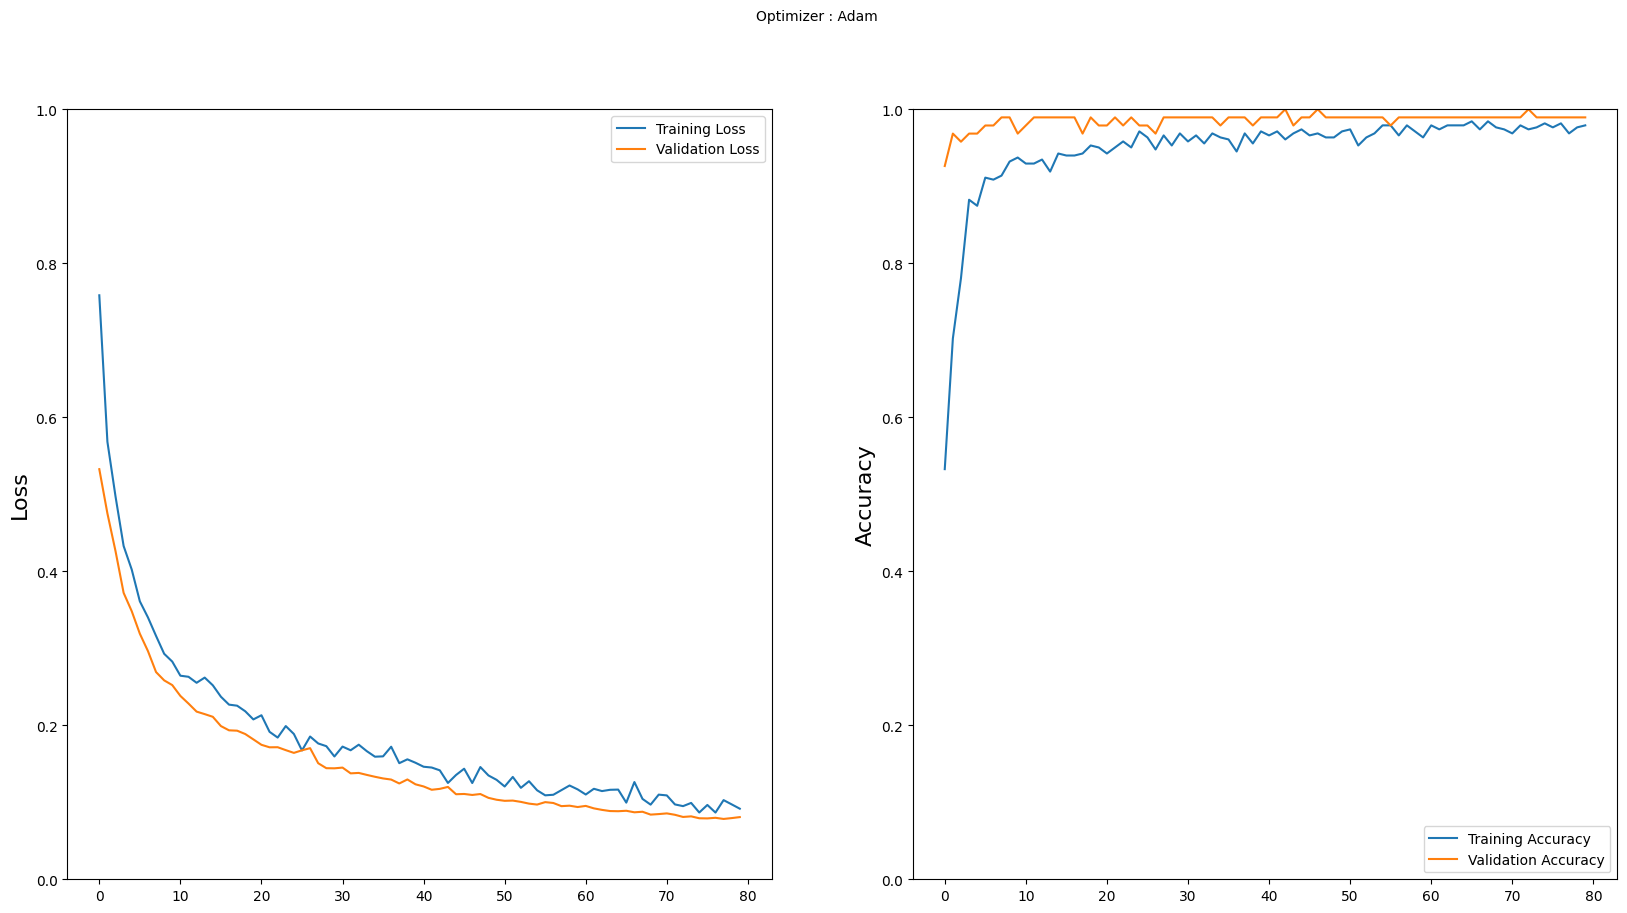

Moyenne des accuracies sur 5 folds: 0.9708


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 2

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/acrima/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]
    train_df_balanced = balance_dataframe(train_df)
    val_df_balanced = balance_dataframe(val_df)

    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    model=create_model()


    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


# Train the model

In [ ]:
model.save('/content/drive/My Drive/glaucomeV16.hdf5')
print("SAVED")

SAVED


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/acrima/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)


Found 140 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step
✅ Accuracy: 95.00%


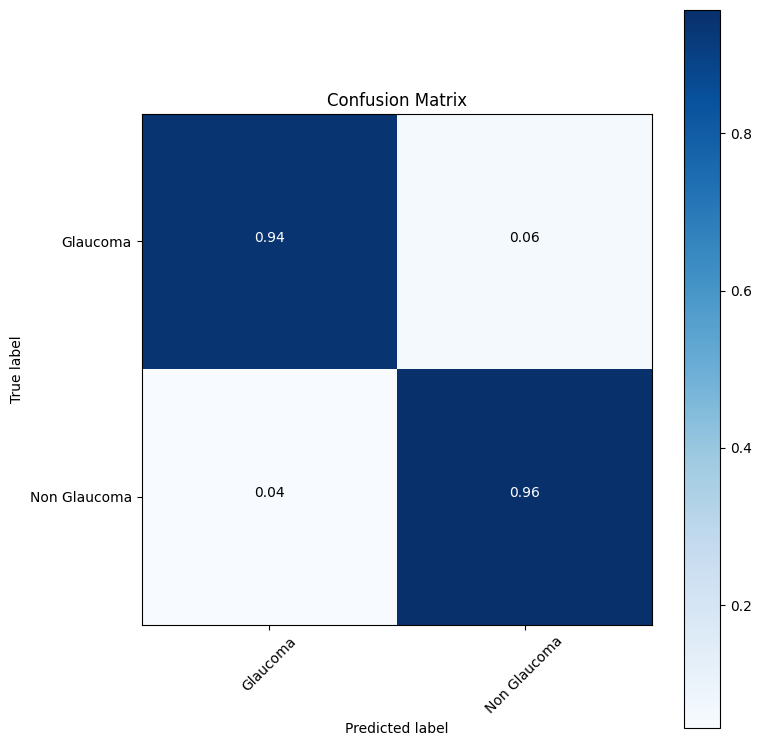

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


predictions = model.predict(test_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()

y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(labels)

y_true = np.array(y_true).astype(int)


cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
class_names = list(train_generator.class_indices.keys())


print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
